* [Introduction](#section-one) 
* [Importing libraries](#section-two) 
* [Loading Data](#section-three)
* [Checking the size of the data base](#section-four)
* [Correlation matrix](#section-five)

<a id="section-one"></a>
# Introduction
 This is my first attempt to create a model to participate in the American Express Challenge to predict credit default.
 
 My main goal is to try to reach a bronze medal, which would require me to rank at least 126th, which has currently a score of 0.796
 
 More on the competition on the link: https://www.kaggle.com/competitions/amex-default-prediction
 
 <a id="section-two"></a>
# Importing Libraries

In [1]:
# Import packages
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import os, gc
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from xgboost import plot_importance

# Import xgb modules
import xgboost as xgb

import cupy, cudf # GPU libraries

 <a id="section-three"></a>
# Loading Data

The code bellow help us open the files in a feather format, which includes all the information, but is much smaller than the original data

In [2]:
def read_file_int(path = '', usecols = None):
    if usecols is not None: df = cudf.read_feather(path, columns=usecols)
    else: df = cudf.read_feather(path)
    df.S_2 = cudf.to_datetime(df.S_2)
    features = [x for x in df.columns.values if x not in ['customer_ID', 'target']]
    df['n_missing'] = df[features].isna().sum(axis=1)
    df = df.fillna(NAN_VALUE) 
    df_out = df.groupby(['customer_ID']).nth(-1).reset_index(drop=True)
    print('shape of data:', df_out.shape)
    del df
    _ = gc.collect()
    return df_out

def read_file_cpu(path = '', usecols = None):
    if usecols is not None: df = pd.read_feather(path, columns=usecols)
    else: df = pd.read_feather(path)
    df.S_2 = pd.to_datetime(df.S_2)
    features = [x for x in df.columns.values if x not in ['customer_ID', 'target']]
    df['n_missing'] = df[features].isna().sum(axis=1)
    df_out = df.groupby(['customer_ID']).nth(-1).reset_index(drop=True)
    print('shape of data:', df_out.shape)
    del df
    _ = gc.collect()
    return df_out

In [3]:
print('Reading train data...')
TRAIN_PATH = '../input/amexfeather/train_data.ftr'
train_df = read_file_cpu(path = TRAIN_PATH)

print('Reading test data...')
TEST_PATH = '../input/amexfeather/test_data.ftr'
test_df = read_file_cpu(path = TEST_PATH)

Reading train data...
shape of data: (458913, 191)
Reading test data...
shape of data: (924621, 190)


 <a id="section-three"></a>
# Checking the size of the data base

In [4]:
from humanize import naturalsize
size = train_df.memory_usage(deep='True').sum()
print(size)
print(naturalsize(size))

178520101
178.5 MB


In [5]:
print(f'Train data memory usage: {naturalsize(train_df.memory_usage(deep="True").sum())} ')
print(f'Test data memory usage:  {naturalsize(test_df.memory_usage(deep="True").sum())}')

Train data memory usage: 178.5 MB 
Test data memory usage:  352.3 MB


 <a id="section-five"></a>
# Correlation Matrix

The code bellow finds the most correlated features and exclude them from exclude them from the database.

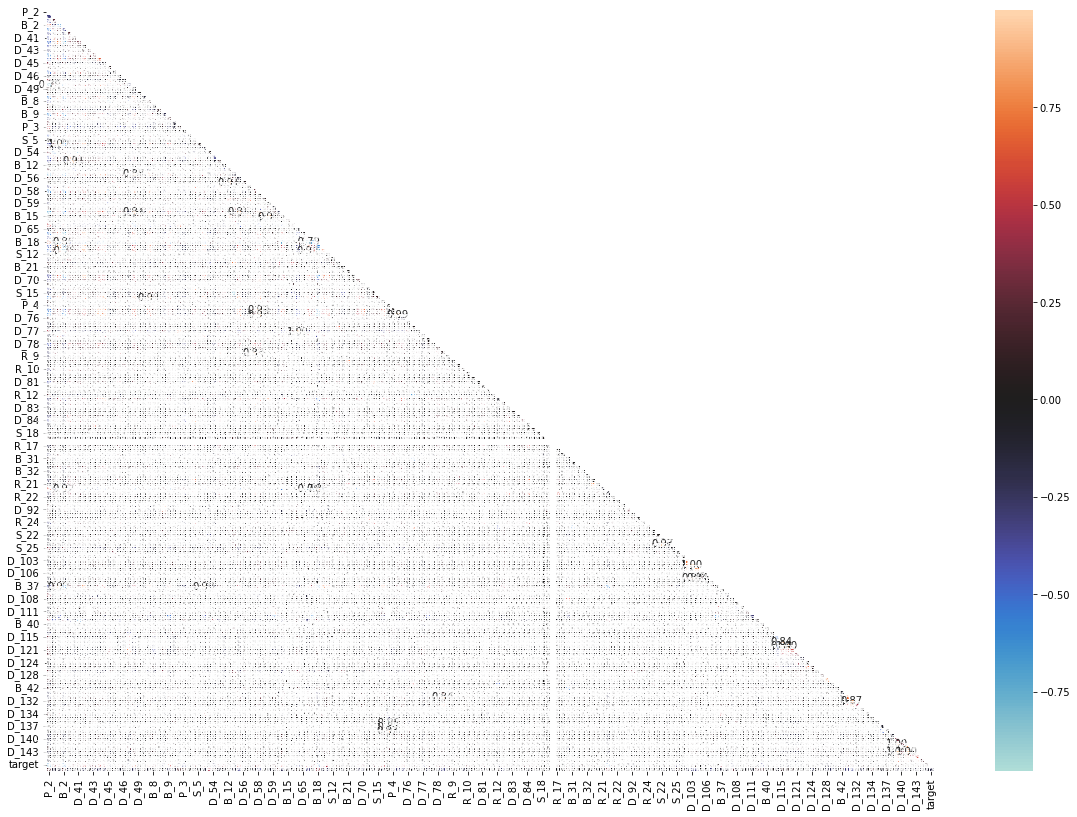

In [6]:
# Correlation matrix
corr = train_df.corr()
# Mask the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Add the mask to the heatmap
fig, ax = plt.subplots(1, 1, figsize=(20,14))
sns.heatmap(corr, mask=mask, center=0, linewidths=1, annot=True, fmt=".2f", ax=ax)
plt.show()

In [7]:
# Remove highly correlated features
corr_matrix = corr.abs()
# Create a boolean mask and apply it
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)

# List column names of highly correlated features (r > 0.7)
to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.7)]
print(f'Number of features: {len(to_drop)} \n {to_drop}')

Number of features: 44 
 ['P_2', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_43', 'D_44', 'B_4', 'D_45', 'R_2', 'D_47', 'D_48', 'B_7', 'D_53', 'B_11', 'B_12', 'S_8', 'D_55', 'R_5', 'D_58', 'B_14', 'D_61', 'D_62', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'D_73', 'D_74', 'D_79', 'S_20', 'S_22', 'D_102', 'D_103', 'D_104', 'D_115', 'D_118', 'D_128', 'D_131', 'D_139', 'D_141']


The code bellow excludes the most hightly correlated features, it's corrently offline.

In [8]:
# Remove the highly correlated features
#train_df = train_df.drop(to_drop, axis=1)
#test_df = test_df.drop(to_drop, axis=1)
#train_df.shape

# Using one hot enconding to transform the categorical collumns

In [9]:
train_df

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target,n_missing
0,2018-03-13,0.934570,0.009117,0.009384,1.007812,0.006104,0.135010,0.001604,0.007175,NaN,...,NaN,0.007187,0.004234,0.005085,NaN,0.005810,0.002970,0.008530,0,26
1,2018-03-25,0.880371,0.178101,0.034698,1.003906,0.006912,0.165527,0.005550,0.005070,NaN,...,NaN,0.002981,0.007481,0.007874,NaN,0.003284,0.003170,0.008514,0,28
2,2018-03-12,0.880859,0.009705,0.004284,0.812500,0.006451,NaN,0.003796,0.007195,NaN,...,NaN,0.007381,0.006622,0.000965,NaN,0.002201,0.000834,0.003445,0,33
3,2018-03-29,0.621582,0.001082,0.012566,1.005859,0.007828,0.287842,0.004532,0.009941,NaN,...,NaN,0.002705,0.006184,0.001899,NaN,0.008186,0.005558,0.002983,0,26
4,2018-03-30,0.872070,0.005573,0.007679,0.815918,0.001247,NaN,0.000231,0.005527,NaN,...,NaN,0.002974,0.004162,0.005764,NaN,0.008156,0.006943,0.000905,0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458908,2018-03-31,0.844238,0.447510,0.028519,1.009766,0.001928,0.128662,0.003483,0.005894,NaN,...,NaN,0.007919,0.001519,0.005531,NaN,0.001431,0.003010,0.004845,0,28
458909,2018-03-22,0.831055,0.033661,0.292480,0.055664,0.006954,NaN,0.005791,0.233032,NaN,...,NaN,0.004395,0.006184,0.001479,NaN,0.004795,0.009232,0.006435,0,29
458910,2018-03-07,0.800293,0.267090,0.020569,1.006836,0.000957,0.066650,0.007423,0.006313,NaN,...,NaN,0.006035,0.002869,0.002150,NaN,0.008034,0.000340,0.002148,0,25
458911,2018-03-23,0.753906,0.008621,0.015839,0.714355,0.000993,0.408936,0.003391,0.050049,NaN,...,NaN,1.009766,0.004478,0.949707,0.446289,1.009766,0.002502,0.185547,1,27


In [10]:
test_df

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,n_missing
0,2019-10-12,0.568848,0.121399,0.010780,1.009766,0.006924,0.149414,0.000396,0.003576,0.103760,...,NaN,NaN,0.005913,0.001250,0.006542,NaN,0.009163,0.003691,0.003220,26
1,2019-04-15,0.841309,0.126465,0.016556,1.008789,0.009712,0.112183,0.006191,0.011383,NaN,...,NaN,NaN,0.004345,0.000866,0.009117,NaN,0.002197,0.000247,0.007778,29
2,2019-10-16,0.697754,0.002724,0.001485,0.810059,0.002621,0.166138,0.004887,0.015945,NaN,...,NaN,NaN,1.000977,0.008896,0.895996,0.150146,1.009766,0.457764,0.092041,24
3,2019-04-22,0.513184,0.324707,0.149536,0.205688,0.002277,0.181152,0.005814,0.498535,NaN,...,NaN,NaN,1.007812,0.003754,0.919922,0.255371,1.007812,0.500977,0.182983,26
4,2019-10-22,0.254395,0.768066,0.563477,0.038025,0.502930,0.168335,0.009483,0.831055,NaN,...,NaN,NaN,0.006622,0.001140,0.009529,NaN,0.009407,0.001557,0.000525,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924616,2019-04-14,0.646973,0.003872,0.011307,0.816895,0.003811,0.162964,0.008942,0.028900,NaN,...,NaN,NaN,0.003016,0.006851,0.009308,NaN,0.009392,0.003279,0.005295,28
924617,2019-10-19,0.471191,0.001856,0.084167,0.082520,0.508789,0.856934,0.000462,0.070496,NaN,...,NaN,NaN,0.007683,0.003374,0.009781,NaN,0.008110,0.005432,0.009979,23
924618,2019-04-06,0.206421,0.001038,0.019958,1.003906,0.009598,0.321045,0.077759,0.014290,NaN,...,NaN,NaN,0.002304,0.001640,0.002371,NaN,0.008156,0.004848,0.002119,22
924619,2019-04-08,0.570801,0.034210,0.049774,0.192871,0.002750,0.230835,0.001869,0.099915,NaN,...,NaN,NaN,0.005352,0.000086,0.003914,NaN,0.003855,0.007481,0.006962,27


In [11]:
train_df['target'].value_counts()

0    340085
1    118828
Name: target, dtype: int64

According to the chagellenge paga, the categorical collumns are:

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [12]:
one_hot_encoding_list = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
one_hot_encoding_list_count = len(one_hot_encoding_list)
print('There are', one_hot_encoding_list_count, 'variables that will be One Hot Encoded, and they are: \n', one_hot_encoding_list, '\n')

There are 11 variables that will be One Hot Encoded, and they are: 
 ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68'] 



In [13]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

one_hot_encoding_train_df = pd.DataFrame(OH_encoder.fit_transform(train_df[one_hot_encoding_list]))
one_hot_encoding_test_df = pd.DataFrame(OH_encoder.transform(test_df[one_hot_encoding_list]))

# One-hot encoding removed index; put it back
one_hot_encoding_train_df.index = train_df.index
one_hot_encoding_test_df.index = test_df.index

one_hot_encoding_train_df.columns = OH_encoder.get_feature_names_out()
one_hot_encoding_test_df.columns = one_hot_encoding_train_df.columns

one_hot_encoding_train_df

,B_30_0.0,B_30_1.0,B_30_2.0,B_30_nan,B_38_1.0,B_38_2.0,B_38_3.0,B_38_4.0,B_38_5.0,B_38_6.0,...,D_64_U,D_66_1.0,D_66_nan,D_68_1.0,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0,D_68_nan
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458908,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
458909,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
458910,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
458911,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [14]:
dates = train_df['S_2']
dates_test = test_df['S_2']
dates

0        2018-03-13
1        2018-03-25
2        2018-03-12
3        2018-03-29
4        2018-03-30
            ...    
458908   2018-03-31
458909   2018-03-22
458910   2018-03-07
458911   2018-03-23
458912   2018-03-14
Name: S_2, Length: 458913, dtype: datetime64[ns]

In [15]:
num_features = train_df._get_numeric_data()
num_features_test = test_df._get_numeric_data()
num_features

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target,n_missing
0,0.934570,0.009117,0.009384,1.007812,0.006104,0.135010,0.001604,0.007175,NaN,NaN,...,NaN,0.007187,0.004234,0.005085,NaN,0.005810,0.002970,0.008530,0,26
1,0.880371,0.178101,0.034698,1.003906,0.006912,0.165527,0.005550,0.005070,NaN,0.060638,...,NaN,0.002981,0.007481,0.007874,NaN,0.003284,0.003170,0.008514,0,28
2,0.880859,0.009705,0.004284,0.812500,0.006451,NaN,0.003796,0.007195,NaN,NaN,...,NaN,0.007381,0.006622,0.000965,NaN,0.002201,0.000834,0.003445,0,33
3,0.621582,0.001082,0.012566,1.005859,0.007828,0.287842,0.004532,0.009941,NaN,0.046112,...,NaN,0.002705,0.006184,0.001899,NaN,0.008186,0.005558,0.002983,0,26
4,0.872070,0.005573,0.007679,0.815918,0.001247,NaN,0.000231,0.005527,NaN,0.044678,...,NaN,0.002974,0.004162,0.005764,NaN,0.008156,0.006943,0.000905,0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458908,0.844238,0.447510,0.028519,1.009766,0.001928,0.128662,0.003483,0.005894,NaN,0.113037,...,NaN,0.007919,0.001519,0.005531,NaN,0.001431,0.003010,0.004845,0,28
458909,0.831055,0.033661,0.292480,0.055664,0.006954,NaN,0.005791,0.233032,NaN,0.134521,...,NaN,0.004395,0.006184,0.001479,NaN,0.004795,0.009232,0.006435,0,29
458910,0.800293,0.267090,0.020569,1.006836,0.000957,0.066650,0.007423,0.006313,NaN,0.049774,...,NaN,0.006035,0.002869,0.002150,NaN,0.008034,0.000340,0.002148,0,25
458911,0.753906,0.008621,0.015839,0.714355,0.000993,0.408936,0.003391,0.050049,NaN,0.046112,...,NaN,1.009766,0.004478,0.949707,0.446289,1.009766,0.002502,0.185547,1,27


In [16]:
train_df = pd.concat([dates, num_features, one_hot_encoding_train_df], axis = 1)
train_df

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_64_U,D_66_1.0,D_66_nan,D_68_1.0,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0,D_68_nan
0,2018-03-13,0.934570,0.009117,0.009384,1.007812,0.006104,0.135010,0.001604,0.007175,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2018-03-25,0.880371,0.178101,0.034698,1.003906,0.006912,0.165527,0.005550,0.005070,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2018-03-12,0.880859,0.009705,0.004284,0.812500,0.006451,NaN,0.003796,0.007195,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2018-03-29,0.621582,0.001082,0.012566,1.005859,0.007828,0.287842,0.004532,0.009941,NaN,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2018-03-30,0.872070,0.005573,0.007679,0.815918,0.001247,NaN,0.000231,0.005527,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458908,2018-03-31,0.844238,0.447510,0.028519,1.009766,0.001928,0.128662,0.003483,0.005894,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
458909,2018-03-22,0.831055,0.033661,0.292480,0.055664,0.006954,NaN,0.005791,0.233032,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
458910,2018-03-07,0.800293,0.267090,0.020569,1.006836,0.000957,0.066650,0.007423,0.006313,NaN,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
458911,2018-03-23,0.753906,0.008621,0.015839,0.714355,0.000993,0.408936,0.003391,0.050049,NaN,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [17]:
train_df['S_2']

0        2018-03-13
1        2018-03-25
2        2018-03-12
3        2018-03-29
4        2018-03-30
            ...    
458908   2018-03-31
458909   2018-03-22
458910   2018-03-07
458911   2018-03-23
458912   2018-03-14
Name: S_2, Length: 458913, dtype: datetime64[ns]

In [18]:
test_df = pd.concat([dates_test, num_features_test, one_hot_encoding_test_df], axis = 1)
test_df

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_64_U,D_66_1.0,D_66_nan,D_68_1.0,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0,D_68_nan
0,2019-10-12,0.568848,0.121399,0.010780,1.009766,0.006924,0.149414,0.000396,0.003576,0.103760,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2019-04-15,0.841309,0.126465,0.016556,1.008789,0.009712,0.112183,0.006191,0.011383,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2019-10-16,0.697754,0.002724,0.001485,0.810059,0.002621,0.166138,0.004887,0.015945,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2019-04-22,0.513184,0.324707,0.149536,0.205688,0.002277,0.181152,0.005814,0.498535,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2019-10-22,0.254395,0.768066,0.563477,0.038025,0.502930,0.168335,0.009483,0.831055,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924616,2019-04-14,0.646973,0.003872,0.011307,0.816895,0.003811,0.162964,0.008942,0.028900,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
924617,2019-10-19,0.471191,0.001856,0.084167,0.082520,0.508789,0.856934,0.000462,0.070496,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
924618,2019-04-06,0.206421,0.001038,0.019958,1.003906,0.009598,0.321045,0.077759,0.014290,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
924619,2019-04-08,0.570801,0.034210,0.049774,0.192871,0.002750,0.230835,0.001869,0.099915,NaN,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [19]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [20]:
train_df

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_64_U,D_66_1.0,D_66_nan,D_68_1.0,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0,D_68_nan
0,2018-03-13,0.934570,0.009117,0.009384,1.007812,0.006104,0.135010,0.001604,0.007175,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2018-03-25,0.880371,0.178101,0.034698,1.003906,0.006912,0.165527,0.005550,0.005070,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2018-03-12,0.880859,0.009705,0.004284,0.812500,0.006451,0.000000,0.003796,0.007195,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2018-03-29,0.621582,0.001082,0.012566,1.005859,0.007828,0.287842,0.004532,0.009941,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2018-03-30,0.872070,0.005573,0.007679,0.815918,0.001247,0.000000,0.000231,0.005527,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458908,2018-03-31,0.844238,0.447510,0.028519,1.009766,0.001928,0.128662,0.003483,0.005894,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
458909,2018-03-22,0.831055,0.033661,0.292480,0.055664,0.006954,0.000000,0.005791,0.233032,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
458910,2018-03-07,0.800293,0.267090,0.020569,1.006836,0.000957,0.066650,0.007423,0.006313,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
458911,2018-03-23,0.753906,0.008621,0.015839,0.714355,0.000993,0.408936,0.003391,0.050049,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [21]:
test_df

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_64_U,D_66_1.0,D_66_nan,D_68_1.0,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0,D_68_nan
0,2019-10-12,0.568848,0.121399,0.010780,1.009766,0.006924,0.149414,0.000396,0.003576,0.103760,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2019-04-15,0.841309,0.126465,0.016556,1.008789,0.009712,0.112183,0.006191,0.011383,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2019-10-16,0.697754,0.002724,0.001485,0.810059,0.002621,0.166138,0.004887,0.015945,0.000000,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2019-04-22,0.513184,0.324707,0.149536,0.205688,0.002277,0.181152,0.005814,0.498535,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2019-10-22,0.254395,0.768066,0.563477,0.038025,0.502930,0.168335,0.009483,0.831055,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924616,2019-04-14,0.646973,0.003872,0.011307,0.816895,0.003811,0.162964,0.008942,0.028900,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
924617,2019-10-19,0.471191,0.001856,0.084167,0.082520,0.508789,0.856934,0.000462,0.070496,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
924618,2019-04-06,0.206421,0.001038,0.019958,1.003906,0.009598,0.321045,0.077759,0.014290,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
924619,2019-04-08,0.570801,0.034210,0.049774,0.192871,0.002750,0.230835,0.001869,0.099915,0.000000,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [22]:
train_df['day_of_month'] = train_df['S_2'].dt.day
train_df['month'] = train_df['S_2'].dt.month
train_df['year'] = train_df['S_2'].dt.year

test_df['day_of_month'] = test_df['S_2'].dt.day
test_df['month'] = test_df['S_2'].dt.month
test_df['year'] = test_df['S_2'].dt.year

In [23]:
train_df

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_68_1.0,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0,D_68_nan,day_of_month,month,year
0,2018-03-13,0.934570,0.009117,0.009384,1.007812,0.006104,0.135010,0.001604,0.007175,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13,3,2018
1,2018-03-25,0.880371,0.178101,0.034698,1.003906,0.006912,0.165527,0.005550,0.005070,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,25,3,2018
2,2018-03-12,0.880859,0.009705,0.004284,0.812500,0.006451,0.000000,0.003796,0.007195,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12,3,2018
3,2018-03-29,0.621582,0.001082,0.012566,1.005859,0.007828,0.287842,0.004532,0.009941,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,29,3,2018
4,2018-03-30,0.872070,0.005573,0.007679,0.815918,0.001247,0.000000,0.000231,0.005527,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30,3,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458908,2018-03-31,0.844238,0.447510,0.028519,1.009766,0.001928,0.128662,0.003483,0.005894,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,31,3,2018
458909,2018-03-22,0.831055,0.033661,0.292480,0.055664,0.006954,0.000000,0.005791,0.233032,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,22,3,2018
458910,2018-03-07,0.800293,0.267090,0.020569,1.006836,0.000957,0.066650,0.007423,0.006313,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7,3,2018
458911,2018-03-23,0.753906,0.008621,0.015839,0.714355,0.000993,0.408936,0.003391,0.050049,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,23,3,2018


In [24]:
test_df

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_68_1.0,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0,D_68_nan,day_of_month,month,year
0,2019-10-12,0.568848,0.121399,0.010780,1.009766,0.006924,0.149414,0.000396,0.003576,0.103760,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12,10,2019
1,2019-04-15,0.841309,0.126465,0.016556,1.008789,0.009712,0.112183,0.006191,0.011383,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,15,4,2019
2,2019-10-16,0.697754,0.002724,0.001485,0.810059,0.002621,0.166138,0.004887,0.015945,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,16,10,2019
3,2019-04-22,0.513184,0.324707,0.149536,0.205688,0.002277,0.181152,0.005814,0.498535,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,22,4,2019
4,2019-10-22,0.254395,0.768066,0.563477,0.038025,0.502930,0.168335,0.009483,0.831055,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,22,10,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924616,2019-04-14,0.646973,0.003872,0.011307,0.816895,0.003811,0.162964,0.008942,0.028900,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,14,4,2019
924617,2019-10-19,0.471191,0.001856,0.084167,0.082520,0.508789,0.856934,0.000462,0.070496,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,19,10,2019
924618,2019-04-06,0.206421,0.001038,0.019958,1.003906,0.009598,0.321045,0.077759,0.014290,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6,4,2019
924619,2019-04-08,0.570801,0.034210,0.049774,0.192871,0.002750,0.230835,0.001869,0.099915,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8,4,2019


D_* = Delinquency variables
S_* = Spend variables
P_* = Payment variables
B_* = Balance variables
R_* = Risk variables

delinquency_variables = ['D_39', 'D_41', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 
                         'D_60', 'D_61', 'D_62', 'D_65', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 
                         'D_84', 'D_86', 'D_87', 'D_88', 'D_89', 'D_91', 'D_92', 'D_93', 'D_94', 'D_96', 'D_102', 'D_103', 'D_104', 'D_105', 'D_106', 'D_107', 'D_108', 'D_109', 
                         'D_110', 'D_111', 'D_112', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_127', 'D_128', 'D_129', 'D_130', 'D_131',
                         'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144', 'D_145']


spend_variables = ['S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_18', 'S_19', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27']

payment_variables = ['P_2', 'P_3', 'P_4']

balance_variables = ['B_1', 'B_2', 'B_3', 'B_4','B_6', 'B_7', 'B_8','B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15','B_16','B_17','B_18','B_19','B_20','B_21','B_22',
                     'B_23','B_24', 'B_25', 'B_26','B_27','B_28','B_29', 'B_31', 'B_32', 'B_33', 'B_36', 'B_37', 'B_40', 'B_41', 'B_42']

risk_variables = ['R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_16', 'R_17', 'R_18', 'R_19',
                  'R_20', 'R_21', 'R_22', 'R_23', 'R_24', 'R_25', 'R_26', 'R_27', 'R_28']

D = train_df[delinquency_variables]
S = train_df[spend_variables]
P = train_df[payment_variables]
B = train_df[balance_variables]
R = train_df[risk_variables]

D_test = test_df[delinquency_variables]
S_test = test_df[spend_variables]
P_test = test_df[payment_variables]
B_test = test_df[balance_variables]
R_test = test_df[risk_variables]

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
train_df["Cluster1"] = kmeans.fit_predict(D)
train_df["Cluster2"] = kmeans.fit_predict(S)
train_df["Cluster3"] = kmeans.fit_predict(P)
train_df["Cluster4"] = kmeans.fit_predict(B)
train_df["Cluster5"] = kmeans.fit_predict(R)

test_df["Cluster1"] = kmeans.fit_predict(D_test)
test_df["Cluster2"] = kmeans.fit_predict(S_test)
test_df["Cluster3"] = kmeans.fit_predict(P_test)
test_df["Cluster4"] = kmeans.fit_predict(B_test)
test_df["Cluster5"] = kmeans.fit_predict(R_test)

train_df

In [25]:
variables = ['D_39', 'P_2']

d_59 = train_df[variables]
d_59_test = test_df[variables]

from sklearn.cluster import KMeans 
kmeans = KMeans(n_clusters=4) 
train_df["Cluster"] = kmeans.fit_predict(d_59) 
test_df["Cluster"] = kmeans.fit_predict(d_59_test)


# Data set for analysis

The code bellow separates Target from Train

In [26]:
target = train_df['target']
train_df = train_df.drop(['target'], axis=1)
train_df.shape

(458913, 233)

# Competition Metrics

The competition is metric performance is measured according to the code bellow

In [27]:
def amex_metric_numpy(y_true: np.array, y_pred: np.array) -> float:

    # count of positives and negatives
    n_pos = np.sum(y_true)
    n_neg = y_true.shape[0] - n_pos

    # sorting by describing prediction values
    indices = np.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = np.sum(target[four_pct_mask]) / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)

# Modelling

In [28]:
num_features = train_df._get_numeric_data().columns
num_features

Index(['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42',
       'D_43',
       ...
       'D_68_2.0', 'D_68_3.0', 'D_68_4.0', 'D_68_5.0', 'D_68_6.0', 'D_68_nan',
       'day_of_month', 'month', 'year', 'Cluster'],
      dtype='object', length=232)

In [29]:
# Create the arrays for features and the target: X, y
X, y = train_df._get_numeric_data(), target

In [30]:
# Create the training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=100, stratify=y)

In [31]:
xg_cl = XGBClassifier(objective='binary:logistic', 
                      n_estimators=100,
                      seed=123,
                      use_label_encoder=False,
                      eval_metric='aucpr', # updated to make use of the aucpr option
                      early_stopping_rounds=10,
                      tree_method='gpu_hist',
                      enable_categorical=True
                      )
eval_set = [(X_test, y_test)]

In [32]:
# Fit the classifier
xg_cl.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-aucpr:0.83819
[1]	validation_0-aucpr:0.85133
[2]	validation_0-aucpr:0.85618
[3]	validation_0-aucpr:0.86029
[4]	validation_0-aucpr:0.86397
[5]	validation_0-aucpr:0.86695
[6]	validation_0-aucpr:0.86893
[7]	validation_0-aucpr:0.87071
[8]	validation_0-aucpr:0.87235
[9]	validation_0-aucpr:0.87375
[10]	validation_0-aucpr:0.87521
[11]	validation_0-aucpr:0.87675
[12]	validation_0-aucpr:0.87753
[13]	validation_0-aucpr:0.87843
[14]	validation_0-aucpr:0.87914
[15]	validation_0-aucpr:0.87983
[16]	validation_0-aucpr:0.88057
[17]	validation_0-aucpr:0.88113
[18]	validation_0-aucpr:0.88185
[19]	validation_0-aucpr:0.88244
[20]	validation_0-aucpr:0.88290
[21]	validation_0-aucpr:0.88335
[22]	validation_0-aucpr:0.88357
[23]	validation_0-aucpr:0.88382
[24]	validation_0-aucpr:0.88414
[25]	validation_0-aucpr:0.88453
[26]	validation_0-aucpr:0.88475
[27]	validation_0-aucpr:0.88488
[28]	validation_0-aucpr:0.88512
[29]	validation_0-aucpr:0.88543
[30]	validation_0-aucpr:0.88566
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=True,
              eval_metric='aucpr', gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=0, reg_lambda=1, ...)

In [33]:
# Predict the labels of the test set
preds = xg_cl.predict(X_test)
preds_prob = xg_cl.predict_proba(X_test)[:,1]

# Compute accuracy
accuracy = accuracy_score(y_test, preds)
print(f'accuracy: {accuracy: .2%}')

accuracy:  89.73%


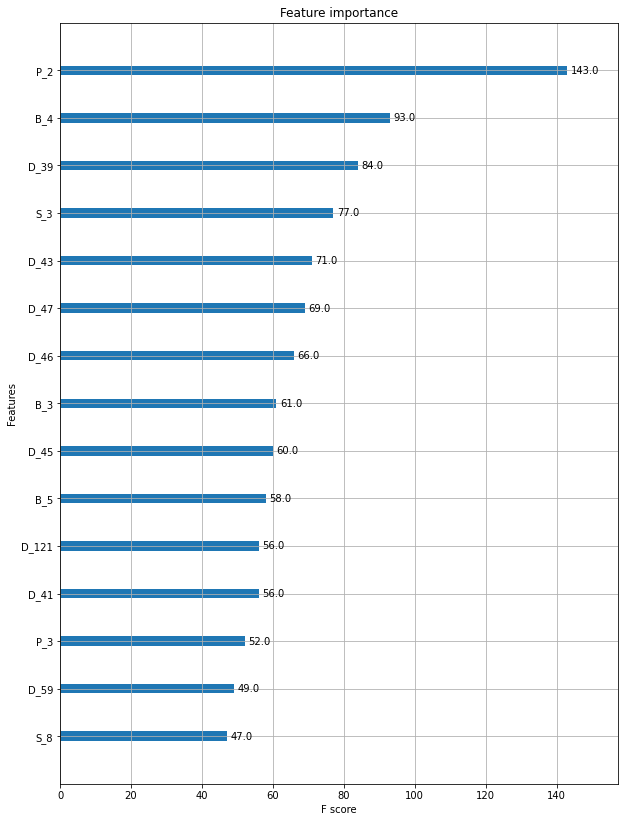

In [34]:
# Review the important features
# print(xg_cl.feature_importances_)
def plot_features(booster, figsize, max_num_features=15):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, max_num_features=max_num_features)
plot_features(xg_cl, (10,14))
plt.show()

In [35]:
print('Metric Evaluation Values\n')
print(f'Numpy: {amex_metric_numpy(y_test.to_numpy().ravel(), preds_prob)}')

Metric Evaluation Values

Numpy: 0.7739611578928667


In [36]:
# Understanding weighted class imbalance
from collections import Counter

counter = Counter(y)
print(counter)

# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Counter({0: 340085, 1: 118828})
Estimate: 2.862


In [37]:
# Create the DMatrix from X and y: churn_dmatrix
d_train = xgb.DMatrix(data=X_train, label=y_train)
d_test = xgb.DMatrix(data=X_test, label=y_test)
xgd_test = xgb.DMatrix(data=test_df._get_numeric_data())

# Create the parameter dictionary: params. NOTE: have to explicitly provide the objective param
params = {"objective":"binary:logistic", 
          "max_depth": 6,
          "eval_metric":'aucpr', # updated to make use of the aucpr option
          "tree_method":'gpu_hist',
          "predictor": 'gpu_predictor',
#           "scale_pos_weight": 30,
         }

# Reviewing the AUC metric
# Perform cross_validation: cv_results
cv_results = xgb.cv(dtrain=d_train, params=params,
                    nfold=5, num_boost_round=60, 
                    metrics="aucpr", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Print the AUC
# print((cv_results["test-auc-mean"]).iloc[-1])
print((cv_results["test-aucpr-mean"]).iloc[-1])

    train-aucpr-mean  train-aucpr-std  test-aucpr-mean  test-aucpr-std
0           0.843640         0.000960         0.839208        0.003396
1           0.857854         0.000537         0.853288        0.003541
2           0.863681         0.000401         0.859118        0.003540
3           0.867863         0.000341         0.862603        0.003632
4           0.871318         0.000438         0.866022        0.003522
5           0.874445         0.000499         0.868754        0.003008
6           0.877175         0.000447         0.871083        0.002730
7           0.879347         0.000573         0.872920        0.002815
8           0.881463         0.000499         0.874816        0.002911
9           0.883419         0.000336         0.876411        0.002935
10          0.885018         0.000355         0.877689        0.002927
11          0.886485         0.000360         0.878849        0.002812
12          0.887771         0.000465         0.879800        0.002765
13    

In [38]:
# Review the train method
params = {
    "objective":"binary:logistic", 
    "max_depth": 6,
    "eval_metric":'aucpr', 
    "tree_method":'gpu_hist',
    "predictor": 'gpu_predictor',
#     "scale_pos_weight": 30,    
}

# train - verbose_eval option switches off the log outputs
xgb_clf = xgb.train(
    params,
    d_train,
    num_boost_round=5000,
    evals=[(d_train, 'train'), (d_test, 'test')],
    early_stopping_rounds=10,
    verbose_eval=True
)

[0]	train-aucpr:0.84393	test-aucpr:0.83819
[1]	train-aucpr:0.85803	test-aucpr:0.85133
[2]	train-aucpr:0.86296	test-aucpr:0.85618
[3]	train-aucpr:0.86715	test-aucpr:0.86029
[4]	train-aucpr:0.87085	test-aucpr:0.86397
[5]	train-aucpr:0.87400	test-aucpr:0.86695
[6]	train-aucpr:0.87631	test-aucpr:0.86893
[7]	train-aucpr:0.87876	test-aucpr:0.87071
[8]	train-aucpr:0.88050	test-aucpr:0.87235
[9]	train-aucpr:0.88230	test-aucpr:0.87375
[10]	train-aucpr:0.88411	test-aucpr:0.87521
[11]	train-aucpr:0.88563	test-aucpr:0.87675
[12]	train-aucpr:0.88677	test-aucpr:0.87753
[13]	train-aucpr:0.88808	test-aucpr:0.87843
[14]	train-aucpr:0.88921	test-aucpr:0.87914
[15]	train-aucpr:0.89013	test-aucpr:0.87983
[16]	train-aucpr:0.89114	test-aucpr:0.88057
[17]	train-aucpr:0.89211	test-aucpr:0.88113
[18]	train-aucpr:0.89322	test-aucpr:0.88185
[19]	train-aucpr:0.89422	test-aucpr:0.88244
[20]	train-aucpr:0.89518	test-aucpr:0.88290
[21]	train-aucpr:0.89595	test-aucpr:0.88335
[22]	train-aucpr:0.89674	test-aucpr:0.8835

In [39]:
# predict
y_pred = xgb_clf.predict(d_test)

# Compute and print metrics
print('Metric Evaluation Values\n')
print(f'Numpy: {amex_metric_numpy(y_test.to_numpy().ravel(), y_pred)}')

Metric Evaluation Values

Numpy: 0.7753520891120006


In [40]:
train_df._get_numeric_data().columns

Index(['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42',
       'D_43',
       ...
       'D_68_2.0', 'D_68_3.0', 'D_68_4.0', 'D_68_5.0', 'D_68_6.0', 'D_68_nan',
       'day_of_month', 'month', 'year', 'Cluster'],
      dtype='object', length=232)

In [41]:
# Lets build using the X_test data - this was to check and see if the code worked. Now going to score up the train_df to get a larger sample
# 1. Predict probability
# rank_data = X_test.copy()
# rank_data['target'] = y_test
# rank_data['prob'] = preds_prob
# rank_data.head()

rank_data = train_df._get_numeric_data()
xgd_rank = xgb.DMatrix(data=train_df._get_numeric_data())
rank_data['prob'] = xgb_clf.predict(xgd_rank)
rank_data['target'] = target
rank_data.head()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_68_4.0,D_68_5.0,D_68_6.0,D_68_nan,day_of_month,month,year,Cluster,prob,target
0,0.934570,0.009117,0.009384,1.007812,0.006104,0.135010,0.001604,0.007175,0.0,0.000000,...,0.0,0.0,1.0,0.0,13,3,2018,3,0.000489,0
1,0.880371,0.178101,0.034698,1.003906,0.006912,0.165527,0.005550,0.005070,0.0,0.060638,...,0.0,0.0,1.0,0.0,25,3,2018,3,0.001142,0
2,0.880859,0.009705,0.004284,0.812500,0.006451,0.000000,0.003796,0.007195,0.0,0.000000,...,0.0,0.0,1.0,0.0,12,3,2018,3,0.002241,0
3,0.621582,0.001082,0.012566,1.005859,0.007828,0.287842,0.004532,0.009941,0.0,0.046112,...,0.0,0.0,0.0,0.0,29,3,2018,3,0.003330,0
4,0.872070,0.005573,0.007679,0.815918,0.001247,0.000000,0.000231,0.005527,0.0,0.044678,...,0.0,0.0,1.0,0.0,30,3,2018,3,0.001692,0


In [42]:
# First create the decile value by prob
rank = rank_data.loc[:, ['target', 'prob']]
rank["ranks"] = rank['prob'].rank(method="first")

# The notes displayed here had related to only using the X_test dataframe. With the train_df being used we can try using the probabilities again
# First method bunchs the final three buckets into one as there are a low of low probs
rank['decile'] = pd.qcut(rank.prob, 10, labels=False, duplicates='drop') 
# Second method aims to use the rank method, however the nature of this rank is still random
# An alternative for this piece might be to put the 'prob' in order and sort by the target
# rank['decile'] = pd.qcut(rank.ranks, 10, labels=False)
# Reviewing the lowest probability
min_prob = np.min(rank.prob)
rank.loc[(rank.prob == min_prob)].head()

,target,prob,ranks,decile
44476,0,0.000032,1.0,0


In [43]:
# Create a rank_order table
def rank_order(df: pd.DataFrame, y: str, target: str) -> pd.DataFrame:
    
    rank = df.groupby('decile').apply(lambda x: pd.Series([
        np.min(x[y]),
        np.max(x[y]),
        np.mean(x[y]),
        np.size(x[y]),
        np.sum(x[target]),
        np.size(x[target][x[target]==0]),
    ],
        index=(["min_prob","max_prob","avg_prob",
               "cnt_cust","cnt_def","cnt_non_def"])
    )).reset_index()
    rank = rank.sort_values(by='decile', ascending=False)
    rank["drate"] = round(rank["cnt_def"]*100/rank["cnt_cust"], 2)
    rank["cum_cust"] = np.cumsum(rank["cnt_cust"])
    rank["cum_def"] = np.cumsum(rank["cnt_def"])
    rank["cum_non_def"] = np.cumsum(rank["cnt_non_def"])
    rank["cum_cust_pct"] = round(rank["cum_cust"]*100/np.sum(rank["cnt_cust"]), 2)
    rank["cum_def_pct"] = round(rank["cum_def"]*100/np.sum(rank["cnt_def"]), 2)
    rank["cum_non_def_pct"] = round(rank["cum_non_def"]*100/np.sum(rank["cnt_non_def"]), 2)
    rank["KS"] = round(rank["cum_def_pct"] - rank["cum_non_def_pct"],2)
    rank["Lift"] = round(rank["cum_def_pct"] / rank["cum_non_def_pct"],2)
    return rank

rank_gains_table = rank_order(rank, "prob", "target")
rank_gains_table

,decile,min_prob,max_prob,avg_prob,cnt_cust,cnt_def,cnt_non_def,drate,cum_cust,cum_def,cum_non_def,cum_cust_pct,cum_def_pct,cum_non_def_pct,KS,Lift
9,9,0.909451,0.999974,0.968441,45891.0,44975.0,916.0,98.00,45891.0,44975.0,916.0,10.0,37.85,0.27,37.58,140.19
8,8,0.681781,0.909449,0.807253,45892.0,38292.0,7600.0,83.44,91783.0,83267.0,8516.0,20.0,70.07,2.50,67.57,28.03
7,7,0.351141,0.681777,0.519922,45891.0,23849.0,22042.0,51.97,137674.0,107116.0,30558.0,30.0,90.14,8.99,81.15,10.03
6,6,0.101826,0.351137,0.210834,45891.0,8834.0,37057.0,19.25,183565.0,115950.0,67615.0,40.0,97.58,19.88,77.70,4.91
5,5,0.025408,0.101815,0.054226,45891.0,2058.0,43833.0,4.48,229456.0,118008.0,111448.0,50.0,99.31,32.77,66.54,3.03
4,4,0.008728,0.025408,0.015235,45892.0,544.0,45348.0,1.19,275348.0,118552.0,156796.0,60.0,99.77,46.10,53.67,2.16
3,3,0.003743,0.008728,0.005795,45891.0,150.0,45741.0,0.33,321239.0,118702.0,202537.0,70.0,99.89,59.55,40.34,1.68
2,2,0.001880,0.003743,0.002678,45891.0,77.0,45814.0,0.17,367130.0,118779.0,248351.0,80.0,99.96,73.03,26.93,1.37
1,1,0.000973,0.001880,0.001388,45891.0,37.0,45854.0,0.08,413021.0,118816.0,294205.0,90.0,99.99,86.51,13.48,1.16
0,0,0.000032,0.000973,0.000608,45892.0,12.0,45880.0,0.03,458913.0,118828.0,340085.0,100.0,100.00,100.00,0.00,1.00


In [44]:
# Score up the test dataset
test_preds = xgb_clf.predict(xgd_test)
test_preds.view()

array([0.07077491, 0.00075091, 0.01752145, ..., 0.40240887, 0.22329135,
       0.10700782], dtype=float32)

In [45]:
# Make submission
sub_data = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')
sub_data.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0


In [46]:
sub_data['prediction'] = test_preds
sub_data.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.070775
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.000751
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.017521
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.262419
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.903306


In [47]:
# Submission file
sub_data.to_csv('submission.csv', index=False)

In [48]:
sub_data.describe()

,prediction
count,924621.000000
mean,0.259117
std,0.354355
min,0.000028
25%,0.002900
50%,0.028847
75%,0.517667
max,0.999982
